# Exploratory Data Analysis for the Delta Analytics Teaching Fellowship

**Author:** *Cynthia Thinwa*

## INTRODUCTION

### DATA HANDLING PRACTICES:

* Based on Twitter API best practice, the actual data will not be shared, only Twitter's tweet IDs for future reference
* The data will be cleaned to remove personally identifiable information like emails and phone numbers
* Exploratory Data Analysis will be described here purely for the basis of describing how the dataset was aggregated in order to be fed into the ML model

Data collection was done from a Microsoft command line running

`twint -s %23kot --since "2020-06-01 03:00:00" --until "2021-06-01 03:00:00" -o kotdata.csv --csv`

## EXPLORATORY DATA ANALYSIS

### Introduction

The raw data was loaded as follows, with the following characteristics:

1. The number of tweets:

In [1]:
import numpy as np
import pandas as pd
import os
import json

In [2]:
%load_ext rpy2.ipython

c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R

library(dplyr)
library(wordcloud)
library(RColorBrewer)
library(rtweet)
library(tidytext)
library(ggplot2)
library(wordcloud2)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: RColorBrewer



In [4]:
%%R

url <- "C:/storage/Personal drive backup/Career/Post-Masters/Delta Analytics Teaching Fellowship/EDA/2.kotdata.csv"
DATFdata <- read.delim(url)
dim(DATFdata)[1]

[1] 36305



2. The number of unique conversations had:


In [5]:
%%R

DATFdata$conversation_id <- factor(DATFdata$conversation_id)
DATFdata$id <- factor(DATFdata$id)

dim(as.data.frame(table(DATFdata$conversation_id)))[1]

[1] 35388



3. The number of unique users speaking:


In [6]:
%%R

DATFdata$user_id <- factor(DATFdata$user_id)

dim(as.data.frame(table(DATFdata$user_id)))[1]

[1] 11049



4. The most frequent language of posting:


In [7]:
%%R

lang <- as.data.frame(table(DATFdata$language))
colnames(lang) <- c('Language','Frequency')
head(lang[order(lang$Freq, decreasing = TRUE),],n=1)

  Language Frequency
8       en     27504



5. The date on which most tweets were posted (tweets were from 1st June 2020 UTC+3 upto 1st June 2021 UTC+3): 


In [8]:
%%R

dates <- as.data.frame(table(DATFdata$date))
colnames(dates) <- c('Date','Frequency')
head(dates[order(dates$Freq, decreasing = TRUE),],n=1)

          Date Frequency
262 2021-02-17       406



### Text transformation

Text cleaning was as follows, using `eng_tweets$tweet[4]` as an example:


In [9]:
%%R

# Get organic tweets first; found that all tweets were organic!

# get only English ones:
eng_tweets <- DATFdata[DATFdata$language=='en',]; print(eng_tweets$tweet[4])

# Remove funny symbols
eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'UTF-8', to = 'ISO-8859-1', sub = ''); print(eng_tweets$tweet[4])

eng_tweets$tweet <- iconv(eng_tweets$tweet, from = 'ISO-8859-1', to = 'UTF-8', sub = ''); print(eng_tweets$tweet[4])

eng_tweets$tweet <- gsub("https\\S*", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove urls

eng_tweets$tweet <- gsub("@\\S*", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove mentions

eng_tweets$tweet <- gsub("#\\S*", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove hashtags

eng_tweets$tweet <- gsub("[\r\n]", " ", eng_tweets$tweet); print(eng_tweets$tweet[4]) #remove newline characters

#(we have separate columns with the details)
# Punctuation was managed as follows:
eng_tweets$tweet <- gsub("'", "", eng_tweets$tweet); print(eng_tweets$tweet[4])

eng_tweets$tweet <- gsub("[[:punct:]]", " ", eng_tweets$tweet); print(eng_tweets$tweet[4])

eng_tweets$tweet <- gsub("amp", "", eng_tweets$tweet); print(eng_tweets$tweet[4]) # remove ampersands

# Finally, everything was made lowercase
eng_tweets$tweet <- tolower(eng_tweets$tweet); print(eng_tweets$tweet[4])

[1]


From cffi callback <function _consolewrite_ex at 0x0000017B59DA7280>:
Traceback (most recent call last):
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\users\ct\appdata\local\programs\python\python39\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 292: invalid continuation byte


[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "
[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "
[1] "@ManUnitedZone_ Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to @LasetoAbdaz @babazubeyyr @VictorWanyama #KOT.I insist,The First Kenyan to play for Manchester United .you'll land in trouble for misinforming the masses "
[1] " Made in the streets of mathare,Nairobi,kenya . He was nicknamed Kenyan Messi.Pride of kenya .Friends to    #KOT.I insist,The First Kenyan to play for M

In [10]:
%%R

# Tokenize words
Words <- eng_tweets %>%
  select(tweet) %>%
  unnest_tokens(word, tweet)


### Word Frequency


Selecting by n


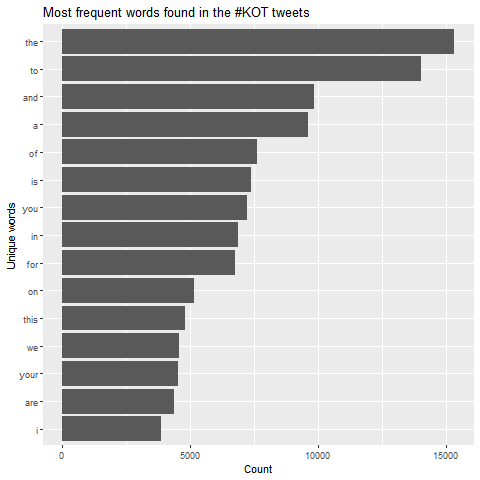

In [11]:
%%R

Words %>% # gives you a bar chart of the most frequent words found in the tweets
  count(word, sort = TRUE) %>%
  top_n(15) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
  labs(y = "Count",
       x = "Unique words",
       title = "Most frequent words found in the #KOT tweets")

Joining, by = "word"
Selecting by n


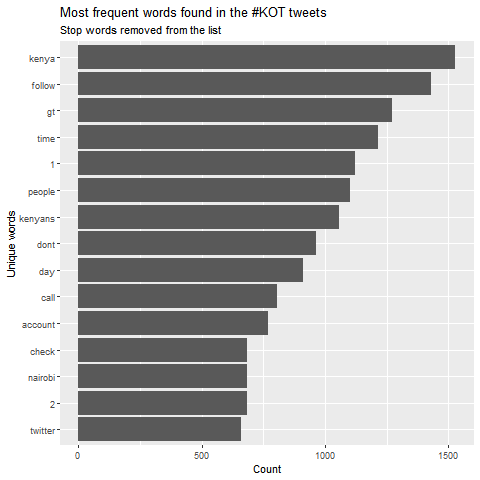

In [12]:
%%R

# remove stop words
Words <- Words %>%
  anti_join(stop_words)

Words %>% # gives you a bar chart of the most frequent words found in the tweets
  count(word, sort = TRUE) %>%
  top_n(15) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
  labs(y = "Count",
       x = "Unique words",
       title = "Most frequent words found in the #KOT tweets",
       subtitle = "Stop words removed from the list")


### Hashtag Frequency

All tweets have the hashtag `#KOT`, but we are interested in what else this community talks about, so this hashtag will have to be removed from our visualization.


In [13]:
%%R

eng_tweets$hashtags <- as.character(eng_tweets$hashtags)

eng_tweets$hashtags <- gsub("[[:punct:]]", "", eng_tweets$hashtags)

# every hashtag was made lowercase
eng_tweets$hashtags <- tolower(eng_tweets$hashtags)

# and #KOT was removed before tokenization
eng_tweets$hashtags <- gsub("kot", "", eng_tweets$hashtags)

Hashtags <- eng_tweets %>%
  select(hashtags) %>%
  unnest_tokens(word, hashtags)

Hashtags_count <- as.data.frame(table(Hashtags$word))

viz1 <- wordcloud2(Hashtags_count, size=0.7); viz1


### People of Influence

In this area, we are interested in identifying people mentioned most frequently.

The text, using `eng_tweets$mentions[4]` as an example was first converted as follows:


In [14]:
%%R

eng_tweets$mentions[4]
# Remove funny symbols
eng_tweets$mentions <- iconv(eng_tweets$mentions, from = 'UTF-8', to = 'UTF-8');eng_tweets$mentions[4]

eng_tweets$mentions <- stringr::str_replace_all(
  eng_tweets$mentions, "\'", "\"")
eng_tweets$mentions <- gsub("[", "", eng_tweets$mentions, fixed = TRUE)
eng_tweets$mentions <- gsub("]", "", eng_tweets$mentions, fixed = TRUE)

df <- as.data.frame(eng_tweets$mentions); dim(df)
df[df == ""] <- NA  
df <- na.omit(df); dim(df)


[1] 6887    1


In [15]:
#get file location
os.getcwd()

'C:\\Users\\CT\\Documents\\GitHub\\Delta-Analytics-2021-CT-Project'

In [16]:
%%R

write.csv(df$`eng_tweets$mentions`,'C:/Users/CT/Documents/GitHub/Delta-Analytics-2021-CT-Project/dicts.csv')

In [17]:
dicts = pd.read_csv('dicts.csv')
dicts.head(5)

,Unnamed: 0,x
0,1,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""..."
1,2,"{""screen_name"": ""gracekuriake"", ""name"": ""grace..."
2,3,"{""screen_name"": ""bravinyuri"", ""name"": ""bravin ..."
3,4,"{""screen_name"": ""ukinkenya"", ""name"": ""uk in ke..."
4,5,"{""screen_name"": ""shopmduka"", ""name"": ""mduka"", ..."


In [18]:
# Delete the column
dicts = dicts.drop(labels='Unnamed: 0', axis=1)
dicts.shape

(6887, 1)

In [19]:
dicts.head(5)

,x
0,"{""screen_name"": ""lasetoabdaz"", ""name"": ""abdaz""..."
1,"{""screen_name"": ""gracekuriake"", ""name"": ""grace..."
2,"{""screen_name"": ""bravinyuri"", ""name"": ""bravin ..."
3,"{""screen_name"": ""ukinkenya"", ""name"": ""uk in ke..."
4,"{""screen_name"": ""shopmduka"", ""name"": ""mduka"", ..."


In [23]:
single_dicts_copy = dicts.copy()
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace('{','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace('}','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace(' ','',regex=False)
single_dicts_copy.iloc[:,0] = single_dicts_copy.iloc[:,0].str.replace("\"",'',regex=False)
single_dicts_copy.columns = ['dictionary']
print(single_dicts_copy.iloc[0,0],'\n')
print(single_dicts_copy.iloc[1,0])

screen_name:lasetoabdaz,name:abdaz,id:502972112,screen_name:babazubeyyr,name:<U+0001F40E>,id:1379069357683322886,screen_name:victorwanyama,name:victorwanyama,id:327549892 

screen_name:gracekuriake,name:gracekuria,id:2172617474


In [21]:
long_lst = list(single_dicts_copy.iloc[:,0].values)
info = []
i=0

for i in range(len(single_dicts_copy.iloc[:,0])):
    item = long_lst[i].split(",")
    info.append(item)

len(info)
info[0]

['screen_name:lasetoabdaz',
 'name:abdaz',
 'id:502972112',
 'screen_name:babazubeyyr',
 'name:<U+0001F40E>',
 'id:1379069357683322886',
 'screen_name:victorwanyama',
 'name:victorwanyama',
 'id:327549892']